### Bibliotecas

In [1]:
import pandas as pd
import numpy as np
import yfinance as yf
import talib as ta
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import BaseCrossValidator, GridSearchCV, cross_val_score, KFold
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, roc_auc_score,ConfusionMatrixDisplay, confusion_matrix, classification_report
from sklearn.tree import DecisionTreeClassifier
import plotly_express as px
import plotly.graph_objects as go
from itertools import combinations
import pickle
# Retirar os avisos de SettingWithCopyWarning 
pd.options.mode.chained_assignment = None
#Retirar os avisos de FutureWarning
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

### Função Principal(Extração/Tratamento dos dados e Criação do modelo)

In [2]:
class Dados():
    def __init__(self) -> None:
        pass
    def Carregar_dados(self,ativo_name='^BVSP',start='2002-01-01',end='2022-01-01'):
        df = yf.download(ativo_name,start,end)
        df['Target'] = np.where(df['Adj Close'].shift(-1).pct_change() > 0, 1, 0)
        self.data = df
        self.data_og = df
    def Variaveis(self,categoria='binario'):
        df = self.data
        high = df['High']
        low = df['Low']
        close = df['Adj Close']
        volume = df['Volume']
    
    
        df['CCI'] = ta.CCI(high,low,close,timeperiod=14) #Patel
        
        df['RSI'] = ta.RSI(close,timeperiod=14) #Patel
        
        #Stochastic KD:
        numerator = df['Adj Close'] - df['Low'].rolling(25).min()
        denominator = df['High'].rolling(25).max() - df['Low'].rolling(25).min()
        df['%K'] =  (numerator/denominator) * 100 #Patel
        
        df['%D'] = df['%K'].rolling(window=3).mean() #Patel
        
        #Larry WIlliam's R%
        numerator = df['High'].rolling(window=25).max() - df['Adj Close']
        denominator = df['High'].rolling(window=25).max() - df['Low'].rolling(window=25).min()
        df['%R'] = (numerator/denominator) * 100 #Patel
        
        #MACD
        df['MACD'] = df['Adj Close'].ewm(span=12).mean() - df['Adj Close'].ewm(span=26).mean() # Patel
        
        #ADOSC - Chaikin A/D Oscillator
        df['A/D'] = ta.ADOSC(high,low,close,volume) #Patel

        #Momento
        df['Momento'] = df['Adj Close'] - df['Adj Close'].shift(9)
        df = df.dropna() 
        
        if categoria == 'binario':
            df['CCI_bin'] = np.where(
                np.logical_or(df['CCI'] <= -100,np.logical_and(df['CCI'] > df['CCI'].shift(),df['CCI'] <= 100))
                ,1
                ,0
                )
            df['RSI_bin'] = np.where(
            np.logical_or(df['RSI'] <= 30,np.logical_and(df['RSI'] > df['RSI'].shift(),df['RSI'] <= 70))
            ,1
            ,0
            ) 
            df['%K_bin'] = np.where(df['%K'] > df['%K'].shift(),1,0)
            df['%D_bin'] = np.where(df['%D'] > df['%D'].shift(),1,0)
            df['%R_bin'] = np.where(df['%R'] > df['%R'].shift(),1,0)
            df['MACD_bin'] = np.where(df['MACD'] > 0 , 1,0)
            df['A/D_bin'] = np.where(df['A/D'] > df['A/D'].shift(),1,0)
            df['Momento_bin'] = np.where(df['Momento'] > 0 , 1, 0)
            colunas_bin = [x for x in list(df.columns) if '_bin' in x ]
            self.data = df[['Target'] + colunas_bin]
        elif categoria == 'continua':
            self.data = df[df.columns[6:]]  
        self.categoria = categoria
    
    def train_test_split(self,tamanho_treinamento = 0.8):
        df = self.data
        tamanho_train = int(len(df) * tamanho_treinamento)
        tipo = StandardScaler()
        # X
        X_train = df.iloc[:tamanho_train,1:]
        X_test = df.iloc[tamanho_train:,1:]

        # # Transformando
        if self.categoria == 'continua':
            X_train = tipo.fit_transform(X_train)
            X_test = tipo.transform(X_test)

        #  Y
        y_train = df.iloc[:tamanho_train,0]
        y_test = df.iloc[tamanho_train:,0]
        
        self.X_train = X_train
        self.X_test = X_test
        self.y_train = y_train
        self.y_test = y_test
    def run_model_gridsearch(self,modelo,nome_modelo):
        modelo.fit(self.X_train,self.y_train)
        results = modelo.cv_results_['mean_test_score']
        params = modelo.cv_results_['params']
        df_result = pd.DataFrame({'params':params,
                                'mean roc auc':results})
        # Salvando Resultados
        df_result.to_csv(f'./resultados/{nome_modelo}.csv')
        # Salvando Modelo
        with open(f'./Modelos/{nome_modelo}.pkl','wb') as file:
            pickle.dump(modelo,file)
        self.modelo = modelo
        return 

### Função da Combinatorial Purged Cross-Validation Method

In [3]:
class cpcv(BaseCrossValidator):
    def __init__(self, n_splits, n_test_splits,intervalo=15):
        self.n_splits = n_splits
        self.n_test_splits = n_test_splits
        self.intervalo = intervalo
    def _generate_selected_fold_bounds(self, fold_bounds):
        lista_folds_test = list(combinations(fold_bounds, self.n_test_splits))
        # selected_fold_bounds = selected_fold_bounds[:self.n_splits]  # Keep only the required number of splits
        return lista_folds_test
    def split(self, X, y=None, groups=None):
        n_samples = list(range(len(X)))
        # Geração dos folds
        fold_bounds = [(fold[0], fold[-1] + 1) for fold in np.array_split(n_samples, self.n_splits)]
        # Análise Combinatória dos Folds
        lista_folds_test = self._generate_selected_fold_bounds(fold_bounds)
        lista_folds_test.reverse() # Selected bounds
        self.n_splits = lista_folds_test #Para puxar numero splits certo
        for folds_teste in lista_folds_test:
            teste_indices = []
            train_indices = []
            folds_train = [fold_train for fold_train in fold_bounds if fold_train not in folds_teste ]
            for start_test,end_test in folds_teste:
                intervalo_fold_test = list(range(start_test,end_test))
                teste_indices.extend(intervalo_fold_test)
                for pos,(start_train,end_train) in enumerate(folds_train):        
                    # Caso 1:
                    if start_test - self.intervalo in range(start_train,end_train):
                        folds_train[pos] = (start_train, end_train - self.intervalo)
                    # Caso 2: 
                    if end_test + self.intervalo in range(start_train,end_train):
                        folds_train[pos] = (start_train + self.intervalo, end_train)
            for start_train, end_train in folds_train:
                intervalo_fold_train = list(range(start_train,end_train))
                train_indices.extend(intervalo_fold_train)
            
            yield train_indices, teste_indices
    
    def get_n_splits(self, X=None, y=None, groups=None):
        n_samples = len(X)
        fold_bounds = [(fold[0], fold[-1] + 1) for fold in np.array_split(list(range(n_samples)), self.n_splits)]
        selected_fold_bounds = self._generate_selected_fold_bounds(fold_bounds)
        return len(selected_fold_bounds)

### Comparando K-Fold com CPCV


#### Rodando os modelos

##### Rodando Random Forest

In [4]:
# Argumentos:
tipo_dado = 'binario'
cv = cpcv(n_splits=5,n_test_splits=2,intervalo=15)
params = {'random_state':[0],
        'max_features':[1,2,3],
        'min_weight_fraction_leaf':[0.01,0.02,0.03,0.04,0.05],
        'class_weight':['balanced_subsample'],
        'criterion':['entropy'],
        'n_estimators':[1000]
      }

nome_modelo = f'GridSearch_RF_CPCV_{tipo_dado}'
modelo = RandomForestClassifier()
clf = GridSearchCV(modelo,
                param_grid=params,
                scoring='roc_auc',
                cv=cv,
                verbose=1,
                n_jobs=-1
                )
# Função
funcao_modelo = Dados()
funcao_modelo.Carregar_dados()
funcao_modelo.Variaveis(tipo_dado)
funcao_modelo.train_test_split()
funcao_modelo.run_model_gridsearch(clf,nome_modelo)

[*********************100%%**********************]  1 of 1 completed
Fitting 10 folds for each of 15 candidates, totalling 150 fits


In [5]:
# Argumentos:
tipo_dado = 'binario'
cv = KFold(n_splits=5)
params = {'random_state':[0],
        'max_features':[1,2,3],
        'min_weight_fraction_leaf':[0.01,0.02,0.03,0.04,0.05],
        'class_weight':['balanced_subsample'],
        'criterion':['entropy'],
        'n_estimators':[1000]
      }

nome_modelo = f'GridSearch_RF_KFold_{tipo_dado}'
modelo = RandomForestClassifier()
clf = GridSearchCV(modelo,
                param_grid=params,
                scoring='roc_auc',
                cv=cv,
                verbose=1,
                n_jobs=-1
                )
# Função
funcao_modelo = Dados()
funcao_modelo.Carregar_dados()
funcao_modelo.Variaveis(tipo_dado)
funcao_modelo.train_test_split()
funcao_modelo.run_model_gridsearch(clf,nome_modelo)

[*********************100%%**********************]  1 of 1 completed
Fitting 5 folds for each of 15 candidates, totalling 75 fits


##### Rodando Gradiente Boosting Classifier

In [6]:
# Argumentos:
tipo_dado = 'binario'
cv = cpcv(n_splits=5,n_test_splits=2)

params = {'random_state':[0],
        'max_features':[1,2,3],
        'min_weight_fraction_leaf':[0.01,0.02,0.03,0.04,0.05],
        'learning_rate':[0.1,1,10],

      }


nome_modelo = f'GridSearch_GBC_CPCV_{tipo_dado}'
modelo = GradientBoostingClassifier()
clf = GridSearchCV(modelo,
                param_grid=params,
                scoring='accuracy',
                cv=cv,
                verbose=1,
                n_jobs=-1
                )
# Função
funcao_modelo = Dados()
funcao_modelo.Carregar_dados()
funcao_modelo.Variaveis(tipo_dado)
funcao_modelo.train_test_split()
funcao_modelo.run_model_gridsearch(clf,nome_modelo)

[*********************100%%**********************]  1 of 1 completed
Fitting 10 folds for each of 45 candidates, totalling 450 fits


In [7]:
# KFOLD
# Argumentos:
tipo_dado = 'binario'
cv = KFold(n_splits=5)

params = {'random_state':[0],
        'max_features':[1,2,3],
        'min_weight_fraction_leaf':[0.01,0.02,0.03,0.04,0.05],
        'learning_rate':[0.1,1,10],

      }


nome_modelo = f'GridSearch_GBC_KFold_{tipo_dado}'
modelo = GradientBoostingClassifier()
clf = GridSearchCV(modelo,
                param_grid=params,
                scoring='accuracy',
                cv=cv,
                verbose=1,
                n_jobs=-1
                )
# Função
funcao_modelo = Dados()
funcao_modelo.Carregar_dados()
funcao_modelo.Variaveis(tipo_dado)
funcao_modelo.train_test_split()
funcao_modelo.run_model_gridsearch(clf,nome_modelo)

[*********************100%%**********************]  1 of 1 completed
Fitting 5 folds for each of 45 candidates, totalling 225 fits


#### Comparando Resultados K-Fold e CPCV

In [8]:
class check_results():
     def __init__(self,tipo_dado):
          # Carregando Base de Teste:
          funcao_modelo = Dados()
          funcao_modelo.Carregar_dados()
          funcao_modelo.Variaveis(categoria=tipo_dado)
          funcao_modelo.train_test_split()
          X_train = funcao_modelo.X_train
          y_train = funcao_modelo.y_train
          X_test = funcao_modelo.X_test
          y_test = funcao_modelo.y_test
          self.X_train = X_train
          self.X_test = X_test
          self.y_train = y_train
          self.y_test = y_test
     def matriz_confusao_geral(self,arquivo_modelo,tri=False):
          # Carregando Modelo:
          modelo = pickle.load(open(arquivo_modelo,'rb'))
          y_pred = modelo.predict(self.X_test)
          score_test = roc_auc_score(self.y_test,y_pred)
          cm = confusion_matrix(self.y_test,y_pred)
          labels = ['Baixa','Alta']
          cm_display = ConfusionMatrixDisplay(cm,display_labels=labels)
          cm_display.plot()
          cr = classification_report(self.y_test,y_pred,target_names=labels)
          print('roc_auc',round(roc_auc_score(self.y_test,y_pred),3))
          print('acuracy',round(accuracy_score(self.y_test,y_pred),3))
          print('Parametros',modelo.best_params_)
          print(cr)
          self.modelo = modelo
          return cr,cm_display

##### RandomForest

[*********************100%%**********************]  1 of 1 completed
roc_auc 0.534
acuracy 0.533
Parametros {'class_weight': 'balanced_subsample', 'criterion': 'entropy', 'max_features': 1, 'min_weight_fraction_leaf': 0.01, 'n_estimators': 1000, 'random_state': 0}
              precision    recall  f1-score   support

       Baixa       0.51      0.55      0.53       467
        Alta       0.56      0.52      0.54       518

    accuracy                           0.53       985
   macro avg       0.53      0.53      0.53       985
weighted avg       0.54      0.53      0.53       985

[*********************100%%**********************]  1 of 1 completed
roc_auc 0.52
acuracy 0.518
Parametros {'class_weight': 'balanced_subsample', 'criterion': 'entropy', 'max_features': 3, 'min_weight_fraction_leaf': 0.01, 'n_estimators': 1000, 'random_state': 0}
              precision    recall  f1-score   support

       Baixa       0.49      0.57      0.53       467
        Alta       0.55      0.47  

('              precision    recall  f1-score   support\n\n       Baixa       0.49      0.57      0.53       467\n        Alta       0.55      0.47      0.51       518\n\n    accuracy                           0.52       985\n   macro avg       0.52      0.52      0.52       985\nweighted avg       0.52      0.52      0.52       985\n',
 <sklearn.metrics._plot.confusion_matrix.ConfusionMatrixDisplay at 0x7f8f480bfd90>)

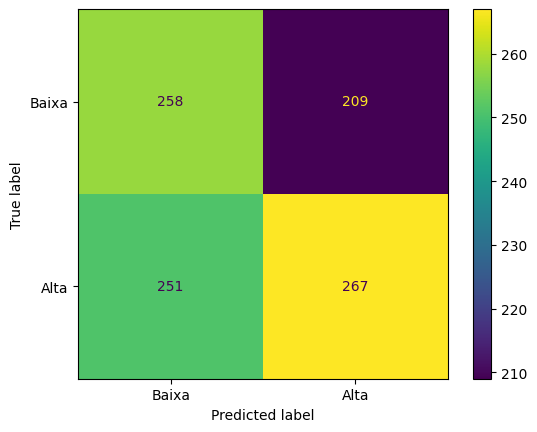

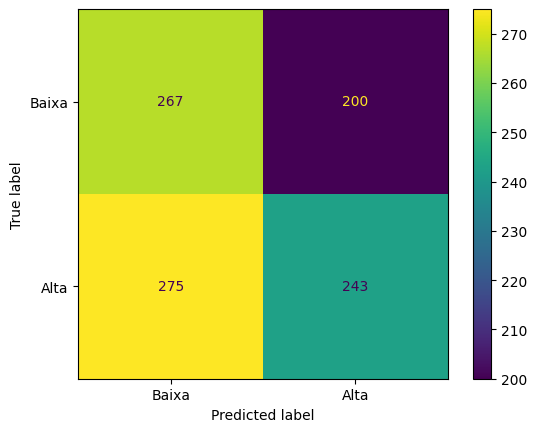

In [5]:
arquivo = './Modelos/GridSearch_RF_CPCV_binario.pkl'
funcao = check_results('binario')
funcao.matriz_confusao_geral(arquivo)
arquivo = './Modelos/GridSearch_RF_KFold_binario.pkl'
funcao = check_results('binario')
funcao.matriz_confusao_geral(arquivo)

##### Gradiente Boosting Classifier

[*********************100%%**********************]  1 of 1 completed
roc_auc 0.543
acuracy 0.552
Parametros {'learning_rate': 0.1, 'max_features': 3, 'min_weight_fraction_leaf': 0.05, 'random_state': 0}
              precision    recall  f1-score   support

       Baixa       0.54      0.36      0.43       467
        Alta       0.56      0.73      0.63       518

    accuracy                           0.55       985
   macro avg       0.55      0.54      0.53       985
weighted avg       0.55      0.55      0.54       985

[*********************100%%**********************]  1 of 1 completed
roc_auc 0.513
acuracy 0.536
Parametros {'learning_rate': 10, 'max_features': 1, 'min_weight_fraction_leaf': 0.01, 'random_state': 0}
              precision    recall  f1-score   support

       Baixa       0.61      0.06      0.11       467
        Alta       0.53      0.97      0.69       518

    accuracy                           0.54       985
   macro avg       0.57      0.51      0.40       

('              precision    recall  f1-score   support\n\n       Baixa       0.61      0.06      0.11       467\n        Alta       0.53      0.97      0.69       518\n\n    accuracy                           0.54       985\n   macro avg       0.57      0.51      0.40       985\nweighted avg       0.57      0.54      0.41       985\n',
 <sklearn.metrics._plot.confusion_matrix.ConfusionMatrixDisplay at 0x7f8ee1ad1e70>)

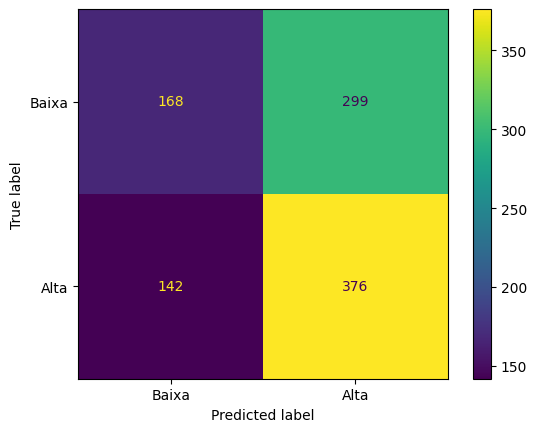

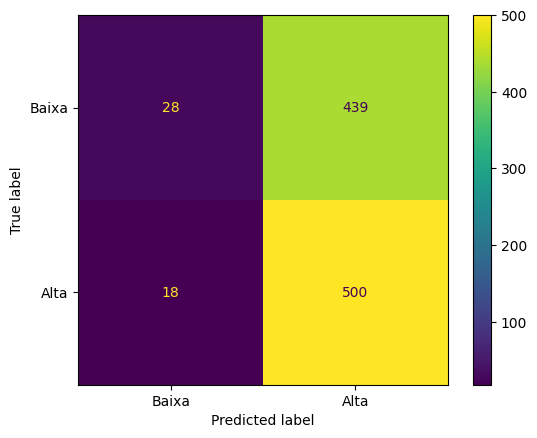

In [9]:
arquivo = './Modelos/GridSearch_GBC_CPCV_binario.pkl'
funcao = check_results('binario')
funcao.matriz_confusao_geral(arquivo)
arquivo = './Modelos/GridSearch_GBC_KFold_binario.pkl'
funcao = check_results('binario')
funcao.matriz_confusao_geral(arquivo)

### Função de Análise do CPCV

##### Considerações: Temos que mudar os argumentos das funções para gerar os resultados corretos

In [18]:
# Iremo primeiro começar com modelo que melhor performou na base de teste : RF Binário.
def score_results(modelo,nome_modelo,X_train,y_train,n_splits=5,n_test_splits=2,intervalo=15):
    # Validação Cruzada
    cv_purge = cpcv(n_splits=n_splits,n_test_splits=n_test_splits,intervalo=intervalo)
    scores = cross_val_score(modelo,X_train,y_train,cv=cv_purge,scoring='roc_auc')
    tipo_dado = 'binario'
    # Salvando Scores da CV
    file_name = f'./resultados/cv_scores/{nome_modelo}_{tipo_dado}_CV_{n_splits}_{n_test_splits}.txt'
    np.savetxt(file_name,scores)
    return scores
def rank_chart_cpcv(arquivo,rank,n_splits,n_test_splits):
  # Carregando Base de Teste:
    funcao_modelo = Dados()
    funcao_modelo.Carregar_dados()
    funcao_modelo.Variaveis(categoria='binario')
    funcao_modelo.train_test_split()
    X_train = funcao_modelo.X_train
    y_train = funcao_modelo.y_train
    X_test = funcao_modelo.X_test
    y_test = funcao_modelo.y_test


    # Abra o arquivo em modo de leitura
    with open(arquivo, 'r') as cv_scores:
        # Leia as linhas do arquivo
        lines = cv_scores.readlines()

    # Remova possíveis caracteres de quebra de linha
    scores = [line.strip() for line in lines]

    # Converta as linhas em um array NumPy
    array_scores = np.array(scores, dtype=float)
    # Criando Df de scores, para organizar em ordem crescente
    df_scores = pd.DataFrame({
        'index':range(len(array_scores)),
        'scores':array_scores
    })
    df_scores.sort_values('scores',ascending=False,inplace=True)
    df_scores.reset_index(inplace=True)

    # Scores
    score = df_scores.iloc[rank,2]
    pos_score = df_scores[df_scores['scores'] == score]['index'].iloc[0]

    # Verificando folds dessa acurácia:

    cv = cpcv(n_splits, n_test_splits) 


    # Crie uma variável para contar os conjuntos
    count = 0

    train_index = []
    test_index = []

    for train_indices, test_indices in cv.split(X_train):
        if count == pos_score:
            train_index.append(train_indices)
            test_index.append(test_indices)
            break
        count += 1
    # Carregando o Fechamento Ibovespa
    df_og = funcao_modelo.data_og

    # Limitando Fechamento para Base de Treino
    tamanho_train = int(len(df_og) * 0.8)
    df_close = df_og.iloc[:tamanho_train]
    df_close_teste = df_og.iloc[tamanho_train:]
    # Pegando valores do IBovespa
    df_close = df_close['Adj Close']
    fechamento_ibovespa = df_close.values

    # # Indices 
    # Indice Completo
    indices_completos = list(range(len(df_close)))
    # Treino
    indices_treino = train_index[0]
    # Teste
    indices_teste = test_index[0]
    # Encontre os índices de overlap
    indices_overlap = [indice for indice in indices_completos if indice not in indices_treino and indice not in indices_teste]

    # Crie um DataFrame do Pandas com os dados
    df = pd.DataFrame({
        'Dia': list(df_close.index),
        'Fechamento': fechamento_ibovespa,
        'Tipo': 'Treino'
    })

    df.loc[indices_teste, 'Tipo'] = 'Teste'
    df.loc[indices_overlap, 'Tipo'] = 'Overlap'

    # Função Para Gerar Base de Dados do Gráfico
    def get_data_chart(df,tipo):
        df_treino = pd.DataFrame({'Dia':[],
                                'Fechamento':[]})
        for i in range(len(df)):
            if df.iloc[i,2] == tipo:
                df_treino.loc[i,'Fechamento'] = df.iloc[i,1]
            else:
                df_treino.loc[i,'Fechamento'] = None
            df_treino.loc[i,'Dia'] = df.iloc[i,0]
        return df_treino
    df_treino = get_data_chart(df,'Treino')
    df_teste = get_data_chart(df,'Teste')
    df_overlap = get_data_chart(df,'Overlap')

    # Gerando Gráfico
    fig = go.Figure()
    fig.add_trace(go.Scatter(x=df_treino['Dia'],
                            y= df_treino['Fechamento'],
                            mode='lines',
                            line={'color':'blue'},
                            name='Treino'
                            ))
    fig.add_trace(go.Scatter(x=df_teste['Dia'],
                            y= df_teste['Fechamento'],
                            mode='lines',
                            line={'color':'red'},
                            name='Teste'
                            ))
    fig.add_trace(go.Scatter(x=df_overlap['Dia'],
                            y= df_overlap['Fechamento'],
                            mode='lines',
                            line={'color':'black'},
                            name='Overlap'
                            ))
    fig.add_trace(go.Scatter(x=df_close_teste.index,
                            y= df_close_teste['Adj Close'],
                            mode='lines',
                            line={'color':'yellow'},
                            name='Dados Nunca Vistos'
                            ))
    fig.update_layout(
        title=f'Roc_Auc:{round(score,3)}',
        yaxis_title = 'Fechamento',
        xaxis_title = 'Data'
    )
    fig.show()

In [22]:
def all_chart_cpcv(arquivo,n_splits=5,n_test_splits=2):
    # Carregando Base de Teste:
    funcao_modelo = Dados()
    funcao_modelo.Carregar_dados()
    funcao_modelo.Variaveis(categoria='binario')
    funcao_modelo.train_test_split()
    X_train = funcao_modelo.X_train
    y_train = funcao_modelo.y_train
    X_test = funcao_modelo.X_test
    y_test = funcao_modelo.y_test

    # Carregando o Fechamento Ibovespa
    df_og = funcao_modelo.data_og

    # Limitando Fechamento para Base de Treino
    tamanho_train = int(len(df_og) * 0.8)
    df_close = df_og.iloc[:tamanho_train]
    df_close_teste = df_og.iloc[tamanho_train:]
    # Lista com Fechamentos
    fechamento_ibovespa = df_close['Adj Close'].values

    # Abra o arquivo em modo de leitura
    with open(arquivo, 'r') as cv_scores:
        # Leia as linhas do arquivo
        lines = cv_scores.readlines()
    # Remova possíveis caracteres de quebra de linha
    scores = [line.strip() for line in lines]

    # Converta as linhas em um array NumPy
    array_scores = np.array(scores, dtype=float)


    # Gerando os Data Frames dos Gráficos de cada CV
    indices_completos = list(range(len(df_close)))

    cv = cpcv(n_splits=5,n_test_splits=2)
    train_index = []
    test_index = []
    overlap_index = []

    for train_indices, test_indices in cv.split(X_train):
        train_index.append(train_indices)
        test_index.append(test_indices)
        # Indice overlap
        indices_overlap = [indice for indice in indices_completos if indice not in train_indices and indice not in test_indices]
        overlap_index.append(indices_overlap)

    # Gerando Gráfico de todas as validações cruzadas:
    # Função Para Gerar Base de Dados do Gráfico
    def get_data_chart(df,tipo):
        df_treino = pd.DataFrame({'Dia':[],
                                'Fechamento':[]})
        for i in range(len(df)):
            if df.iloc[i,2] == tipo:
                df_treino.loc[i,'Fechamento'] = df.iloc[i,1]
            else:
                df_treino.loc[i,'Fechamento'] = None
            df_treino.loc[i,'Dia'] = df.iloc[i,0]
        return df_treino

    for i in range(len(train_index)):
        indices_treino = train_index[i]
        indices_teste = test_index[i]
        indices_overlap = overlap_index[i]
        score = array_scores[i]
        # Crie um DataFrame do Pandas com os dados
        df = pd.DataFrame({
            'Dia': list(df_close.index),
            'Fechamento': fechamento_ibovespa,
            'Tipo': 'Treino'
        })
        df.loc[indices_teste, 'Tipo'] = 'Teste'
        df.loc[indices_overlap, 'Tipo'] = 'Overlap'

        df_treino = get_data_chart(df,'Treino')
        df_teste = get_data_chart(df,'Teste')
        df_overlap = get_data_chart(df,'Overlap')
        # Gerando Gráfico
        fig = go.Figure()
        fig.add_trace(go.Scatter(x=df_treino['Dia'],
                                y= df_treino['Fechamento'],
                                mode='lines',
                                line={'color':'blue'},
                                name='Treino'
                                ))
        fig.add_trace(go.Scatter(x=df_teste['Dia'],
                                y= df_teste['Fechamento'],
                                mode='lines',
                                line={'color':'red'},
                                name='Teste'
                                ))
        fig.add_trace(go.Scatter(x=df_overlap['Dia'],
                                y= df_overlap['Fechamento'],
                                mode='lines',
                                line={'color':'black'},
                                name='Overlap'
                                ))
        fig.add_trace(go.Scatter(x=df_close_teste.index,
                                y= df_close_teste['Adj Close'],
                                mode='lines',
                                line={'color':'yellow'},
                                name='Dados Nunca Vistos'
                                ))
        fig.update_layout(
            title=f'Roc_Auc:{round(score,3)}',
            yaxis_title = 'Fechamento',
            xaxis_title = 'Data'
        )
        fig.show()



In [24]:
# Como nosso modelo está em GridSearch, irei pegar os melhores parâmetros e rodar o modelo com os melhores parâmetros

# Carregando os Dados
funcao_modelo = Dados()
funcao_modelo.Carregar_dados()
funcao_modelo.Variaveis(categoria=tipo_dado)
funcao_modelo.train_test_split()
X_train = funcao_modelo.X_train
y_train = funcao_modelo.y_train
X_test = funcao_modelo.X_test
y_test = funcao_modelo.y_test

# Carregando Modelo
arquivo_modelo_gridsearch = './Modelos/GridSearch_GBC_CPCV_binario.pkl'
modelo_gridsearch = pickle.load(open(arquivo_modelo_gridsearch,'rb'))
params = modelo_gridsearch.best_params_
modelo = GradientBoostingClassifier(**params)
score_results(modelo=modelo,
             nome_modelo='GBC_CPCV',
              X_train=X_train,
              y_train=y_train,)


[*********************100%%**********************]  1 of 1 completed


array([0.50457078, 0.50780488, 0.50265825, 0.5066103 , 0.5093446 ,
       0.51645715, 0.50877224, 0.49969107, 0.48883344, 0.49046334])

In [ ]:
arquivo = './resultados/cv_scores/GBC_CPCV_binario_CV_5_2.txt' # ARGUMENTO
n_splits = 5 # ARGUMENTO
n_test_splits = 2 # ARGUMENTO
all_chart_cpcv(arquivo)

In [ ]:
# Rank 0 => Melhor acurácia
# Rank -1 => Pior acurácia
ranks = [0,-1]
for rank in ranks:
    rank_chart_cpcv(arquivo,rank,n_splits,n_test_splits)

### Montando/Explicando a lógica de como foi montado o CPCV

In [ ]:
# Montando a lógica da CPCV

# Parametros:
n_splits = 4 # Quantidade de Folds que queremos
n_test_splits = 2 # Quantidade de Fold de teste que queremos

# Base de dados Utilizada
n_samples = list(range(400))

# Criação da Lógica:

# Achando os intervalos de cada fold, dado n_splits escolhido
# Obs: esse + 1 em fold[1] + 1, é necessário pois caso não tenha ao juntar os folds de teste irá pular 1 o numero entre eles
fold_bounds = [(fold[0], fold[-1] + 1) for fold in np.array_split(n_samples, n_splits)]
print('Folds utilizados no processo:',fold_bounds)

# Agora que temos o intervalo dos folds, iremos fazer a Análise combinatória dos folds com os folds de teste:
# Como a ordem importa iremos aplicar o conceito de Arranjo
# Nesse caso  Arranjo de 5 escolhe 2(esperamos que dê 10 combinações de folds de testes diferentes):
lista_folds_test = list(combinations(fold_bounds, n_test_splits))
print('folds_test',lista_folds_test)
print('Numero de combinações folds_test:',len(lista_folds_test))

# Agora precisamos aplicar a técnica de Purge e Embargo para que não haja vazamento de dados:
# Percorrendo a lista dos folds de teste:
for folds_teste in lista_folds_test:
    teste_indices = []
    train_indices = []
    # Os folds de treino são aqueles que não encontram no folds totais
    folds_train = [fold_train for fold_train in fold_bounds if fold_train not in folds_teste ]
    # Percorrendo inicio e fim de cada fold de test
    for start_test,end_test in folds_teste:
        # Gerando indices de cada fold de teste
        intervalo_fold_test = list(range(start_test,end_test))
        # Armazenando o indices do fold teste
        teste_indices.extend(intervalo_fold_test)
        # Aplicando Purge... 
        # O Purge ocorre quando temos vazamento de dados do fold de treinamento no fold de teste. Isso ocorre , uma vez que
        # é utilizado variáveis independentes com defasagens temporais.
        # Temos 2 Situações:
        # 1- Quando o fold de test é sucessor de um fold de treinamento. 
        # 2- Quando o fold de treinamento é sucessor de um fold de teste.
        for pos,(start_train,end_train) in enumerate(folds_train):        
            # Caso 1:
            if start_test - 15 in range(start_train,end_train):
                # print('Caso 1')
                folds_train[pos] = (start_train, end_train - 15)
            # Caso 2: 
            if end_test + 15 in range(start_train,end_train):
                # print('Caso 2')
                folds_train[pos] = (start_train + 15, end_train)
    for start_train, end_train in folds_train:
        intervalo_fold_train = list(range(start_train,end_train))
        # Abastecendo train_indices:
        train_indices.extend(intervalo_fold_train)
    
    # Print para verificar se os folds estão corretos
    print('===================================//========//============================')
    print('Fold Treino',folds_train)
    print('Folds Teste:',folds_teste)
    print(teste_indices)
    print(train_indices)
    
    

    

#### Microuniverso para verificação de vazamento de dados

In [ ]:
#Microuniverso para verificação do vazamento de dados:
Folds_Treino = [(100, 200), (300, 400)]
Folds_Teste = ((0, 100), (200, 300))

# Verificando se Há vazamento de Dados:
for start_test,end_test in Folds_Teste:
    # Pegando primeiro Fold de Teste e verificando dentro dos Folds de Treino se há vazamento
    for pos,(start_train,end_train) in enumerate(Folds_Treino):        
        # Caso 1:
        if start_test - 15 in range(start_train,end_train):
            print('Caso 1')
            end_train = end_train - 15
            Folds_Treino[pos] = (start_train, end_train)
        # Caso 2: 
        if end_test + 15 in range(start_train,end_train):
            print('Caso 2')
            start_train = start_train + 15
            Folds_Treino[pos] = (start_train, end_train)